# PyESAPI: Data Mining
*By Michael.Folkerts@varian.com*

In [1]:
import pyesapi
import atexit
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')
atexit.register(app.Dispose);

## Extracting Structure Data with Pandas
* Open a patient
* Use pandas dataframe to display basic structure info
* Extract data with loop over many patients
* Save to CSV file

[reference](https://pandas.pydata.org/pandas-docs/stable/tutorials.html)

In [2]:
app.ClosePatient()  # good practice
a_patient = app.OpenPatientById('RapidPlan-01')
a_plan = a_patient.CoursesLot(0).PlanSetupsLot(0)

In [3]:
import pandas as pd

df = pd.DataFrame(
    [(s.Id, s.DicomType, s.Volume, s.IsHighResolution) for s in a_plan.StructureSet.Structures],
    columns = ('StructureId', 'DicomType', 'Volume[cc]', 'IsHighRes')
)
df  # pretty print HTML table
# print(df)  # string print

,StructureId,DicomType,Volume[cc],IsHighRes
0,External,EXTERNAL,39442.979501,False
1,Bladder,ORGAN,387.956598,False
2,CTV Prostate,CTV,35.393592,False
3,z CouchInterior,SUPPORT,14789.423747,False
4,FemoralHead_L,ORGAN,166.430112,False
5,Bowel,ORGAN,589.581268,False
6,PTV,PTV,100.968767,False
7,FemoralHead_R,ORGAN,168.577012,False
8,Rectum,ORGAN,69.587825,False
9,z CouchSurface,SUPPORT,2723.042663,False


In [4]:
def d_at_v(plan,structure,volume):
    _dose=plan.GetDoseAtVolume(structure,volume,
                               pyesapi.VolumePresentation.Relative,
                               pyesapi.DoseValuePresentation.Absolute)
    return _dose.Dose

columns = (
    'PatientId',
    'PlanId',
    'StructureId',
    'DicomType',
    'Volume(cc)',
    'IsHighRes',
    'D95%(Gy)',
    'D25%(Gy)',
    'D50%(Gy)'
)

def get_structure_info(plan):
    return [(
        plan.StructureSet.Patient.Id,
        plan.Id,
        s.Id,
        s.DicomType,
        s.Volume,
        s.IsHighResolution,
        d_at_v(plan,s,95),
        d_at_v(plan,s,25),
        d_at_v(plan,s,50)
    ) for s in plan.StructureSet.Structures]

df = pd.DataFrame(get_structure_info(a_plan),columns=columns)
df  # pretty print HTML table
# print(df)  # string print

,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,RapidPlan-01,RA Calc,External,EXTERNAL,39442.979501,False,0.001006,0.747400,0.151894
1,RapidPlan-01,RA Calc,Bladder,ORGAN,387.956598,False,1.056218,6.851331,3.119362
2,RapidPlan-01,RA Calc,CTV Prostate,CTV,35.393592,False,80.209159,81.334786,80.987743
3,RapidPlan-01,RA Calc,z CouchInterior,SUPPORT,14789.423747,False,NaN,NaN,NaN
4,RapidPlan-01,RA Calc,FemoralHead_L,ORGAN,166.430112,False,1.888115,18.756412,14.393730
5,RapidPlan-01,RA Calc,Bowel,ORGAN,589.581268,False,0.376215,0.919412,0.702133
6,RapidPlan-01,RA Calc,PTV,PTV,100.968767,False,79.862116,81.523899,81.113483
7,RapidPlan-01,RA Calc,FemoralHead_R,ORGAN,168.577012,False,1.672847,20.485591,14.070829
8,RapidPlan-01,RA Calc,Rectum,ORGAN,69.587825,False,1.924328,62.892221,32.191499
9,RapidPlan-01,RA Calc,z CouchSurface,SUPPORT,2723.042663,False,NaN,NaN,NaN


In [5]:
# takes about a minute!
patient_id_list= [
    'RapidPlan-01',
    'RapidPlan-02',
    'RapidPlan-03',
    'RapidPlan-04',
    'RapidPlan-06',
    'Eclipse-01',
    'Eclipse-03',
    'Eclipse-04',
    'Eclipse 06',
    'Eclipse 07',
    'Eclipse 11'
]
dataframe_list = []
for patient_id in patient_id_list:
    print(f'Loading structure data from {patient_id} plans...\t\t',end='\r')
    app.ClosePatient()
    patient = app.OpenPatientById(patient_id)
    for course in patient.Courses:
        for plan in course.PlanSetups:
            if plan.Dose is not None:
                dataframe_list.append(pd.DataFrame(get_structure_info(plan),columns=columns))
print('Done!'+' '*80)

Done!                                                                                


In [6]:
structure_dataframe = pd.concat(dataframe_list,ignore_index=True)
structure_dataframe  # pretty print
# print(structure_dataframe)  # string print

,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,RapidPlan-01,RA Calc,External,EXTERNAL,39442.979501,False,0.001006,0.747400,0.151894
1,RapidPlan-01,RA Calc,Bladder,ORGAN,387.956598,False,1.056218,6.851331,3.119362
2,RapidPlan-01,RA Calc,CTV Prostate,CTV,35.393592,False,80.209159,81.334786,80.987743
3,RapidPlan-01,RA Calc,z CouchInterior,SUPPORT,14789.423747,False,NaN,NaN,NaN
4,RapidPlan-01,RA Calc,FemoralHead_L,ORGAN,166.430112,False,1.888115,18.756412,14.393730
5,RapidPlan-01,RA Calc,Bowel,ORGAN,589.581268,False,0.376215,0.919412,0.702133
6,RapidPlan-01,RA Calc,PTV,PTV,100.968767,False,79.862116,81.523899,81.113483
7,RapidPlan-01,RA Calc,FemoralHead_R,ORGAN,168.577012,False,1.672847,20.485591,14.070829
8,RapidPlan-01,RA Calc,Rectum,ORGAN,69.587825,False,1.924328,62.892221,32.191499
9,RapidPlan-01,RA Calc,z CouchSurface,SUPPORT,2723.042663,False,NaN,NaN,NaN


In [7]:
# if you insist
with open('./StructureData.csv','w') as f:
    f.write(structure_dataframe.to_csv(sep='/'))

## Pandas + SQLite
* Save data into SQLite database
* Run some quieries
* Plot a histogram of selected data

[reference](https://www.dataquest.io/blog/python-pandas-databases/)

In [8]:
import sqlite3

sql_connection = sqlite3.connect("big_data.db")
table_name = 'structure_data'
structure_dataframe.to_sql(table_name,sql_connection, if_exists="replace")  # overwrite table if it exists

In [23]:
df = pd.read_sql_query(f'select * from {table_name} limit 20;', sql_connection)
df
# print(df)

,index,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,0,RapidPlan-01,RA Calc,External,EXTERNAL,39442.979501,0,0.001006,0.747400,0.151894
1,1,RapidPlan-01,RA Calc,Bladder,ORGAN,387.956598,0,1.056218,6.851331,3.119362
2,2,RapidPlan-01,RA Calc,CTV Prostate,CTV,35.393592,0,80.209159,81.334786,80.987743
3,3,RapidPlan-01,RA Calc,z CouchInterior,SUPPORT,14789.423747,0,NaN,NaN,NaN
4,4,RapidPlan-01,RA Calc,FemoralHead_L,ORGAN,166.430112,0,1.888115,18.756412,14.393730
5,5,RapidPlan-01,RA Calc,Bowel,ORGAN,589.581268,0,0.376215,0.919412,0.702133
6,6,RapidPlan-01,RA Calc,PTV,PTV,100.968767,0,79.862116,81.523899,81.113483
7,7,RapidPlan-01,RA Calc,FemoralHead_R,ORGAN,168.577012,0,1.672847,20.485591,14.070829
8,8,RapidPlan-01,RA Calc,Rectum,ORGAN,69.587825,0,1.924328,62.892221,32.191499
9,9,RapidPlan-01,RA Calc,z CouchSurface,SUPPORT,2723.042663,0,NaN,NaN,NaN


In [10]:
ptv_df = pd.read_sql_query(f'select * from {table_name} where DicomType=="PTV" limit 10;', sql_connection)
ptv_df
# print(ptv_df)

,index,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,6,RapidPlan-01,RA Calc,PTV,PTV,100.968767,0,79.862116,81.523899,81.113483
1,11,RapidPlan-02,Boost,PTV_Phase1,PTV,1069.403754,0,0.129401,1.088077,0.389651
2,12,RapidPlan-02,Boost,PTVp,PTV,126.873081,0,18.843981,19.409143,19.267913
3,23,RapidPlan-02,Boost Calc,PTV_Phase1,PTV,1069.403754,0,0.127324,0.971796,0.360545
4,24,RapidPlan-02,Boost Calc,PTVp,PTV,126.873081,0,18.790938,19.410317,19.255657
5,34,RapidPlan-03,H&N Calc,PTV70,PTV,42.097341,0,70.234095,73.203606,72.630875
6,35,RapidPlan-03,H&N Calc,PTV56 Eval,PTV,302.535430,0,56.214419,59.991000,58.946876
7,36,RapidPlan-03,H&N Calc,PTV56,PTV,362.115936,0,56.224372,60.947360,59.212884
8,37,RapidPlan-03,H&N Calc,PTV63 Eval,PTV,121.562603,0,63.726866,68.179323,66.144457
9,38,RapidPlan-03,H&N Calc,PTV63,PTV,166.037148,0,63.846298,71.408508,67.229297


In [11]:
ptv_df.mean()

index          25.600000
Volume(cc)    348.787090
IsHighRes       0.000000
D95%(Gy)       42.799981
D25%(Gy)       45.613303
D50%(Gy)       44.455164
dtype: float64

In [12]:
ptv_df.hist(column='Volume(cc)');

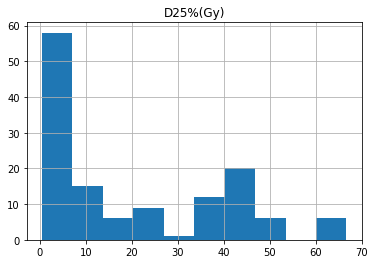

In [13]:
pd.read_sql_query(f'select * from {table_name} where DicomType=="ORGAN";', sql_connection).hist(column='D25%(Gy)');

## Saving DVH to HDF5 Using [H5Py](http://www.h5py.org)
*HDF5 lets you store huge amounts of numerical data, and easily manipulate that data from NumPy.*

Groups = Folders, Datasets = Files

* Create HDF5 file
* Create group for patient data in H5 file
* Get DVH data for a structure and save as dataset
* loop over patients DVH and save data to HDF5 file

In [135]:
import h5py
# you can reuse this code block to reset the file
try:
    h5file.close()
except NameError:
    pass
finally:
    h5file = h5py.File("DVH.h5",'w')  # truncate if exists

In [136]:
app.ClosePatient()
patient = app.OpenPatientById('RapidPlan-01')
patient_group = h5file.create_group(f'patients/{patient.Id}')

In [137]:
for label in h5file:
    print(label)

patients


In [138]:
# works like dictionary
for label in h5file['patients']:
    print(label)

RapidPlan-01


In [139]:
type(courses_group)

h5py._hl.group.Group

In [140]:
def ls(location,depth=0):
    try:
        for key,value in location.items():
            print(' ' * depth + ('\u21b3 ' if depth else '') + key)  # unicode for '↳'
            ls(value,depth+1)
    except:
        pass

In [141]:
ls(h5file)

patients
 ↳ RapidPlan-01


In [142]:
courses_group = patient_group.create_group('courses/')

In [143]:
ls(h5file)

patients
 ↳ RapidPlan-01
  ↳ courses


In [144]:
for course in patient.Courses:
    for plan in course.PlanSetups:
        courses_group.create_group(f'{course.Id}/plans/{plan.Id}')
    
ls(h5file)

patients
 ↳ RapidPlan-01
  ↳ courses
   ↳ C1
    ↳ plans
     ↳ RA Calc


In [145]:
def get_dvh(structure):
    dvh = plan.GetDVHCumulativeData(
        structure,
        pyesapi.DoseValuePresentation.Absolute,
        pyesapi.VolumePresentation.AbsoluteCm3,
        .01
    )
    if dvh is not None:
        dose_x = [p.DoseValue.Dose for p in dvh.CurveData]
        volume_y = [p.Volume for p in dvh.CurveData]
        return dose_x, volume_y
    else:
        return None, None

In [146]:
for course in patient.Courses:
    for plan in course.PlanSetups:
        for structure in plan.StructureSet.Structures:
            dose,vol = get_dvh(structure)
            if dose is not None:
                structure_dvh_group = courses_group.create_group(
                    f'{course.Id}/plans/{plan.Id}/structures/{structure.Id}/dvh'
                )
                structure_dvh_group.create_dataset('dose_gy',data=dose)
                structure_dvh_group.create_dataset('volume_cm3',data=vol)
ls(h5file)

patients
 ↳ RapidPlan-01
  ↳ courses
   ↳ C1
    ↳ plans
     ↳ RA Calc
      ↳ structures
       ↳ Bladder
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
       ↳ Bowel
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
       ↳ CTV Prostate
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
       ↳ External
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
       ↳ FemoralHead_L
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
       ↳ FemoralHead_R
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
       ↳ PTV
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
       ↳ Rectum
        ↳ dvh
         ↳ dose_gy
         ↳ volume_cm3
